##  R-CNN code structure

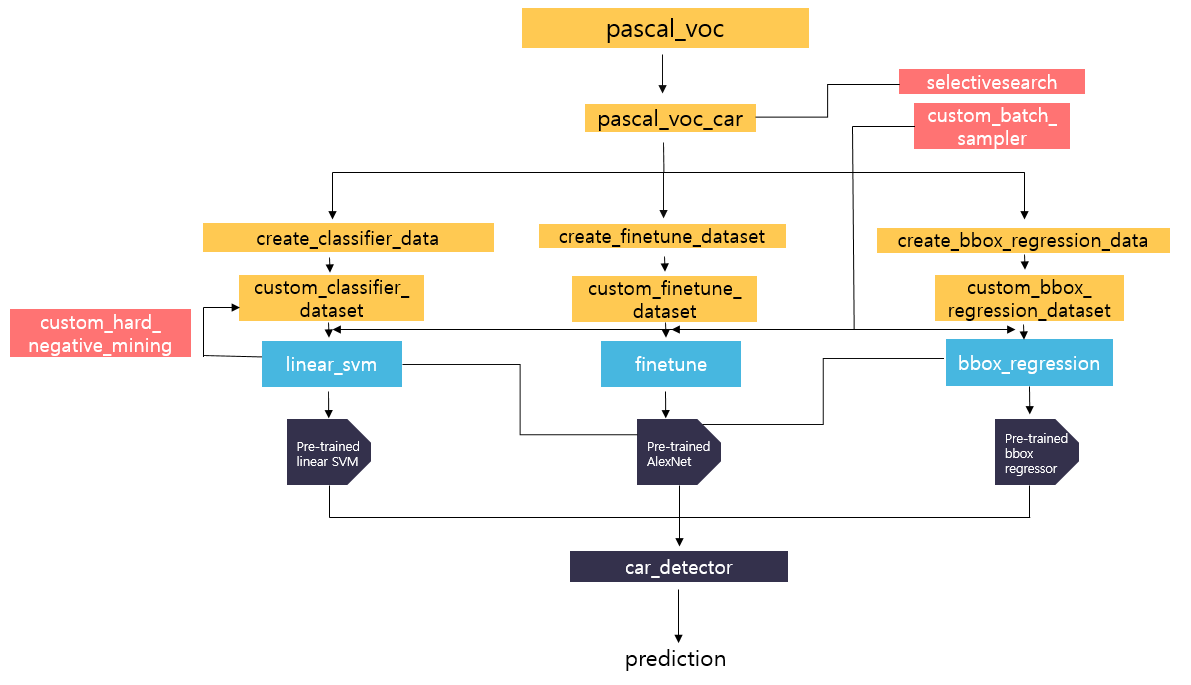
              


# **R-CNN 모델 구조의 특이점**

세 가지 주요 모델:

- fine tuned AlexNet
  : 이미지 특징(feature)을 추출하는 CNN 모델입니다. AlexNet을 미세 조정(finetuning)하여 특정 클래스, 여기서는 "자동차"에 대해 특징을 잘 잡아내도록 학습합니다.
- linear SVM: 서포트 벡터 머신(SVM) 분류기로, R-CNN에서는 객체 검출을 위한 binary classifier로 사용됩니다. 이 모델은 추출된 특징을 통해 "자동차"인지 아닌지를 구별하는 역할을 합니다.


- Bounding box regressor:  Bounding box 위치를 조정하는 모델로, 객체의 위치를 더 정확하게 예측할 수 있도록 합니다.

# **데이터셋 구성**
:각 모델이 학습에 사용하는 데이터셋이 다릅니다. 이는 모델이 각각 positive와 negative 예시를 다르게 정의하고, 다른 기준에 따라 학습 데이터를 필요로 하기 때문입니다.

- AlexNet을 위한 데이터셋

  : create_finetune_dataset 과정을 통해 학습에 사용할 이미지 데이터를 모읍니다.

  이 데이터는 "자동차" 이미지와 기타 다른 이미지로 구성되어, AlexNet이 객체의 특징을 효과적으로 학습하도록 돕습니다.

  결과적으로 custom_finetune_dataset이 만들어지며, 이는 "자동차"라는 개념을 학습하기 위한 이미지 데이터입니다.

- SVM을 위한 데이터셋

  :create_classifier_data 단계에서 SVM 학습용 데이터가 생성됩니다.

  이 데이터셋은 "자동차"와 "자동차가 아닌" 이미지가 필요하며, custom_hard_negative_mining 과정에서 "자동차가 아닌" 데이터에 대한 어려운 예제(모델이 혼동할 수 있는 예제)를 포함시켜 모델 성능을 높입니다.

  결과적으로 custom_classifier_dataset이 만들어지며, SVM이 "자동차"와 "자동차가 아닌" 경우를 잘 분리할 수 있도록 학습됩니다.

- Bounding Box Regressor를 위한 데이터셋

  :create_bbox_regression_data 과정에서는 bounding box 좌표를 더 정확하게 예측하기 위한 데이터가 생성됩니다.

  이는 자동차의 정확한 위치를 잡기 위한 데이터셋으로, "자동차" 위치의 좌표 정보를 포함한 custom_bbox_regression_dataset이 생성됩니다.

# **각각의 학습 과정**

- fine tuned AlexNet

  : custom_finetune_dataset을 통해 AlexNet의 특징 추출 성능을 높입니다.

- linear SVM

  : custom_classifier_dataset을 통해 SVM이 자동차와 자동차가 아닌 것을 구분하도록 학습합니다.

- bbox regressor

  : custom_bbox_regression_dataset을 통해 bounding box를 조정하는 예측 성능을 높입니다.

# **R-CNN 모델 설계 순서**

#### **1.PASCAL VOC 데이터셋 다운로드 및 "car" class 해당하는 데이터만 추출**

>  R-CNN 학습을 위해 필요한 자동차 이미지와 레이블을 준비.

#### **2. 각 모델별 annotation 생성 및 Custom Dataset 정의**

> AlexNet, SVM, Bounding box regressor 각각의 요구에 맞는 데이터셋을 설정.

#### **3. pre-trained된 AlexNet fine tuning**

> 사전 학습된 AlexNet을 사용해 자동차 특징 추출 성능을 개선.

#### *4. linear SVM 및 Bounding box regressor 모델 학습*

> SVM으로 자동차를 분류하고, Bounding box regressor로 위치를 조정.

#### **5. 3가지 모델을 모두 활용하여 detection 수행**

> AlexNet, SVM, Bounding box regressor를 조합해 자동차 탐지 및 위치 예측 수행.

# 1) PASCAL VOC 데이터셋 다운로드 및 Car class에 해당하는 데이터만 추출

VOC2007

├── Annotations

├── ImageSets

├── JPEGImages

├── SegmentationClass

└── SegmentationObject



pascal_voc_car.py
>  ImageSets(class 정보)에 있는 car_trainval.txt 파일을 읽어들여 car에 해당하는 이미지와 xml 파일을 복사하여 별도의 데이터셋을 구축

# 2) 각 모델별 annotation 생성 및 Custom Dataset 정의

- selectivesearch.py : Selective search 알고리즘 수행
- create_finetune_data.py : AlexNet fine tune을 수행하기 위한 annotation 생성
- create_classifier_data.py : linear SVM 학습을 위한 annotation 생성
- create_bbox_regression_data.py : Bounding box regressor 학습을 위한 annotation 생성

## AlexNet 모델을 fine tuning하기 위해 데이터셋의 annotation을 생성

In [ ]:
def parse_annotation_jpeg(annotation_path, jpeg_path, gs):
    # 이미지 불러오기
    img = cv2.imread(jpeg_path)

    # Selective Search를 설정하고 실행하여 region proposals(객체가 있을 법한 사각형 영역) 생성
    selectivesearch.config(gs, img, strategy='q')
    rects = selectivesearch.get_rects(gs)  # region proposals 추출

    # XML 파일에서 ground truth bounding boxes 불러오기
    bndboxs = parse_xml(annotation_path)  # 실제 객체 위치 정보 => 모델이 객체의 실제 위치와 제안된 위치 비교 가능

    # 가장 큰 ground truth bounding box의 크기를 계산 ( negative 샘플을 걸러내기 위한 기준)
    maximum_bndbox_size = 0
    for bndbox in bndboxs:
        xmin, ymin, xmax, ymax = bndbox
        bndbox_size = (ymax - ymin) * (xmax - xmin)
        if bndbox_size > maximum_bndbox_size:
            maximum_bndbox_size = bndbox_size

    # 모든 region proposals와 ground truth 사이의 IoU(두 영역의 겹치는 비율) 값을 계산
    iou_list = compute_ious(rects, bndboxs)

    # Positive와 Negative 샘플을 저장할 리스트 생성
    positive_list = list()
    negative_list = list()

    for i in range(len(iou_list)):
        # 각 region proposal의 좌표 가져오기
        xmin, ymin, xmax, ymax = rects[i]
        rect_size = (ymax - ymin) * (xmax - xmin)

        # 해당 region proposal의 IoU 값 가져오기
        iou_score = iou_list[i]

        # Pre-trained CNN 모델의 fine-tuning 기준에 따른 양성/음성 정의
        # positive : IoU >= 0.5
        # negative : IoU < 0.5
        # IoU가 0.5 이상일 경우 positive로 분류
        if iou_score >= 0.5:
            positive_list.append(rects[i])

        # IoU가 0보다 크고 0.5 미만이면서, 가장 큰 bounding box 크기의 20% 이상일 경우 negative로 분류
        if 0 < iou_score < 0.5 and rect_size > maximum_bndbox_size / 5.0:
            negative_list.append(rects[i])
        else:
            pass  # 조건을 만족하지 않는 경우 무시

    # positive와 negative 리스트 반환
    return positive_list, negative_list



In [ ]:
class CustomFinetuneDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        # root_dir에서 CSV 파일을 읽어와 자동차 이미지 샘플 이름 목록을 가져옵니다.
        samples = parse_car_csv(root_dir)

        # 모든 자동차 이미지를 불러와 jpeg_images 리스트에 저장합니다.
        jpeg_images = [cv2.imread(os.path.join(root_dir, 'JPEGImages', sample_name + ".jpg"))
                       for sample_name in samples]

        # Positive: IoU >= 0.5, Negative: IoU < 0.5
        # 양성 및 음성 annotation 파일을 각각 저장합니다.
        positive_annotations = [os.path.join(root_dir, 'Annotations', sample_name + '_1.csv')
                                for sample_name in samples]
        negative_annotations = [os.path.join(root_dir, 'Annotations', sample_name + '_0.csv')
                                for sample_name in samples]

        # 양성 및 음성 bounding box 크기를 저장할 리스트
        positive_sizes = list()
        negative_sizes = list()

        # 양성 및 음성 bounding box 좌표를 저장할 리스트
        positive_rects = list()
        negative_rects = list()

        # positive_rects = [(x, y, w, h), ....] 형태로 좌표 저장
        # positive_sizes = [1, ....] 형태로 크기 정보 저장
        for annotation_path in positive_annotations:
            # 양성 샘플의 bounding box 좌표를 CSV 파일에서 불러옵니다.
            rects = np.loadtxt(annotation_path, dtype=np.int, delimiter=' ')

            # 파일이 비어 있거나 단일 행만 있는 경우 처리
            if len(rects.shape) == 1:
                # 단일 행인 경우
                if rects.shape[0] == 4:
                    # 좌표가 하나인 경우 positive_rects와 positive_sizes에 각각 추가
                    positive_rects.append(rects)
                    positive_sizes.append(1)
                else:
                    # 데이터가 없는 경우 크기 정보만 0으로 저장
                    positive_sizes.append(0)
            else:
                # 여러 개의 bounding box가 있는 경우
                positive_rects.extend(rects)
                positive_sizes.append(len(rects))


In [ ]:
class BBoxRegressionDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        # 초기화 코드가 여기 들어갑니다.
        (...)

    def __getitem__(self, index: int):
        # 인덱스가 데이터셋 크기를 초과하지 않는지 확인
        assert index < self.__len__(), 'The data set size is %d, and the current input subscript is %d' % (self.__len__(), index)

        # 현재 인덱스에 해당하는 bounding box 정보 가져오기
        box_dict = self.box_list[index]
        image_id = box_dict['image_id']   # 이미지 ID
        positive = box_dict['positive']   # 예측 bounding box 좌표
        bndbox = box_dict['bndbox']       # 실제 ground truth bounding box 좌표

        # 예측 이미지 영역을 가져오기
        jpeg_img = self.jpeg_list[image_id]  # 이미지 ID에 해당하는 원본 이미지
        xmin, ymin, xmax, ymax = positive    # 예측 bounding box 좌표
        image = jpeg_img[ymin:ymax, xmin:xmax]  # bounding box 영역의 이미지 추출

        # transform이 정의되어 있으면 이미지 변환 적용
        if self.transform:
            image = self.transform(image)

        # 예측 bounding box의 너비, 높이 및 중심 좌표 계산
        # p_w, p_h: 예측 bounding box 너비 및 높이
        # p_x, p_y: 예측 bounding box 중심 X, Y 좌표
        p_w = xmax - xmin
        p_h = ymax - ymin
        p_x = xmin + p_w / 2
        p_y = ymin + p_h / 2

        # 실제 ground truth bounding box의 너비, 높이 및 중심 좌표 계산
        # g_w, g_h: 실제 bounding box 너비 및 높이
        # g_x, g_y: 실제 bounding box 중심 X, Y 좌표
        xmin, ymin, xmax, ymax = bndbox
        g_w = xmax - xmin
        g_h = ymax - ymin
        g_x = xmin + g_w / 2
        g_y = ymin + g_h / 2

        # bounding box 변환값 계산 (t_x, t_y, t_w, t_h)
        # t_x, t_y: 실제 중심 좌표와 예측 중심 좌표 간의 X, Y 차이 비율
        # t_w, t_h: 실제 너비와 높이 대비 예측 너비와 높이의 로그 비율
        t_x = (g_x - p_x) / p_w
        t_y = (g_y - p_y) / p_h
        t_w = np.log(g_w / p_w)
        t_h = np.log(g_h / p_h)

        # 이미지와 변환값 반환
        return image, np.array((t_x, t_y, t_w, t_h))


In [ ]:
class CustomBatchSampler(Sampler):

    def __init__(self, num_positive, num_negative, batch_positive, batch_negative) -> None:
        # 양성 및 음성 샘플 개수와 배치당 양성/음성 샘플 수를 초기화
        self.num_positive = num_positive        # 전체 양성 샘플 수
        self.num_negative = num_negative        # 전체 음성 샘플 수
        self.batch_positive = batch_positive    # 배치당 양성 샘플 수
        self.batch_negative = batch_negative    # 배치당 음성 샘플 수
        self.num_iter = (num_positive + num_negative) // (batch_positive + batch_negative)

        # 전체 샘플 인덱스 리스트 생성
        self.idx_list = np.arange(num_positive + num_negative)

    def __iter__(self):
        # 배치를 저장할 리스트 초기화
        sampler_list = list()

        # 각 반복에서 양성/음성 샘플을 뽑아 배치를 구성
        for i in range(self.num_iter):
            # 양성 샘플과 음성 샘플을 각각 지정된 수만큼 랜덤하게 선택
            tmp = np.concatenate(
                (random.sample(self.idx_list[:self.num_positive], self.batch_positive),
                 random.sample(self.idx_list[self.num_positive:], self.batch_negative))
            )
            # 선택한 샘플을 섞어 순서를 무작위로 만들기
            random.shuffle(tmp)

            # 현재 배치를 전체 배치 리스트에 추가
            sampler_list.extend(tmp)

        # iterator를 반환하여 학습 루프에서 사용할 수 있게 함
        return iter(sampler_list)


# 3) pre-trained 된 AlexNet fine tuning

In [ ]:
if __name__ == '__main__':
    # GPU 사용이 가능하면 'cuda:0'를, 그렇지 않으면 'cpu'를 사용
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 데이터 로드: './data/finetune_car'에서 데이터 로드
    # data_loaders는 훈련/검증 데이터를 포함하며, data_sizes는 각 데이터의 크기를 나타냄
    data_loaders, data_sizes = load_data('./data/finetune_car')

    # 사전 학습된(pre-trained) AlexNet 모델 불러오기
    model = models.alexnet(pretrained=True)

    # AlexNet의 마지막 fully connected layer를 새로 정의하기 위해 input feature 수를 가져옴
    num_features = model.classifier[6].in_features
    # 최종 layer를 새로 정의하여 output unit 수를 2로 설정 (자동차 vs 배경)
    model.classifier[6] = nn.Linear(num_features, 2)

    # 모델을 지정된 장치(GPU 또는 CPU)로 이동
    model = model.to(device)

    # 손실 함수로 Cross Entropy Loss 사용
    criterion = nn.CrossEntropyLoss()
    # Stochastic Gradient Descent (SGD) 최적화 함수 사용, 학습률(lr)을 0.001, 모멘텀을 0.9로 설정
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    # 학습률 스케줄러 설정: 7 에포크마다 학습률을 0.1배로 감소시킴
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # 모델 학습 수행: data_loaders, 손실 함수, 최적화 함수, 스케줄러, 장치, 에포크 수(25)를 인자로 전달
    best_model = train_model(data_loaders, model, criterion, optimizer,
                             lr_scheduler, device=device, num_epochs=25)

    # 모델 저장 디렉터리 확인 또는 생성
    check_dir('./models')
    # 학습 완료된 모델의 가중치 저장
    torch.save(best_model.state_dict(), 'models/alexnet_car.pth')


# 4) linear SVM 및 Bounding box regressor 학습

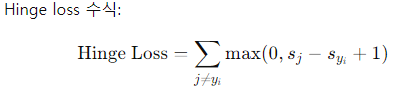


sj는 각 클래스의 confidence score, sy는 실제 클래스의 confidence score입니다.

### **SVM 모델 학습 과정**
- 데이터 구성

  :객체 검출 시, 관심 객체(예: 자동차)만을 양성(positive) 샘플로, 나머지 배경을 음성(negative) 샘플로 취급합니다.

  클래스 불균형 상황에서 양성 샘플이 음성 샘플보다 훨씬 적기 때문에, 학습 초기에는 양성:음성 비율을 1:1로 맞춰 균형을 유지합니다. 이를 통해 SVM이 양성 샘플에 편향되지 않도록 합니다.

- Hinge Loss 사용
  :SVM 모델은 Hinge loss를 손실 함수로 사용하여 예측과 실제 라벨 간의 차이를 최소화합니다.

  Hinge loss는 양성 샘플의 분류 정확도를 강조하는 함수로, 객체 검출의 경우, 분류 경계(margin)를 최대화하여 양성/음성을 구분합니다.

- Hard Negative Mining

  :SVM 학습 중에서 Hard Negative Mining 기법을 사용하여, 모델이 잘못 예측하는 음성 샘플에 대해 더 많이 학습합니다. 이 기법은 모델이 헷갈리기 쉬운 음성 샘플을 반복적으로 학습해 분류 성능을 개선합니다.

In [ ]:
def hinge_loss(outputs, labels):
    # 샘플 개수
    num_labels = len(labels)

    # 실제 클래스의 confidence score 가져오기
    corrects = outputs[range(num_labels), labels].unsqueeze(0).T

    # Hinge Loss의 margin 값 설정 (1.0이 일반적)
    margin = 1.0

    # 모든 클래스의 confidence score와 실제 클래스의 confidence score 간의 마진 차이 계산
    margins = outputs - corrects + margin

    # Hinge loss 계산: 각 샘플에 대해 최대값을 선택하여 평균 손실 구함
    loss = torch.sum(torch.max(margins, 1)[0]) / len(labels)

    # (선택 사항) 정규화 항 추가
    # reg = 1e-3
    # loss += reg * torch.sum(weight ** 2)
    return loss


In [ ]:
def get_hard_negatives(preds, cache_dicts):
    # 예측 결과에서 False Positive와 True Negative 마스크 생성
    fp_mask = preds == 1  # 모델이 positive라고 예측한 경우
    tn_mask = preds == 0  # 모델이 negative라고 예측한 경우

    # False Positive 및 True Negative bounding box 좌표와 이미지 ID 가져오기
    fp_rects = cache_dicts['rect'][fp_mask].numpy()
    fp_image_ids = cache_dicts['image_id'][fp_mask].numpy()

    tn_rects = cache_dicts['rect'][tn_mask].numpy()
    tn_image_ids = cache_dicts['image_id'][tn_mask].numpy()

    # Hard negative 및 Easy negative 리스트 생성
    hard_negative_list = [{'rect': fp_rects[idx], 'image_id': fp_image_ids[idx]} for idx in range(len(fp_rects))]
    easy_negative_list = [{'rect': tn_rects[idx], 'image_id': tn_image_ids[idx]} for idx in range(len(tn_rects))]

    return hard_negative_list, easy_negative_list

In [ ]:
if __name__ == '__main__':
    # 데이터 로드: './data/bbox_regression'에서 데이터 로드
    data_loader = load_data('./data/bbox_regression')

    # 장치 설정: GPU 사용이 가능하면 'cuda:0', 그렇지 않으면 'cpu'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Feature 모델 가져오기 (fine-tuned AlexNet의 출력 특성 사용)
    feature_model = get_model(device)

    # 입력 및 출력 feature 수 설정
    in_features = 256 * 6 * 6  # 특성 맵의 크기
    out_features = 4  # bounding box 좌표 (x, y, width, height)
    model = nn.Linear(in_features, out_features)  # Fully connected layer 추가
    model.to(device)

    # 손실 함수로 Mean Squared Error 사용
    criterion = nn.MSELoss()
    # Adam optimizer 사용, 학습률(lr) 및 weight decay 설정
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    # 학습률 스케줄러 설정: 5 에포크마다 학습률을 0.1배로 감소시킴
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # 모델 학습: feature 모델, bounding box regressor, 손실 함수, 최적화 함수, 학습률 스케줄러 사용
    loss_list = train_model(data_loader, feature_model, model, criterion, optimizer, lr_scheduler, device=device,
                            num_epochs=12)

    # 학습 과정에서의 손실 그래프를 시각화
    util.plot_loss(loss_list)


# 5) 학습시킨 모델을 활용하여 detection 수행

Detection 수행 과정 (car_detector.py)

1) Feature Vector 생성


:fine-tuned AlexNet을 사용하여 입력 이미지에서 feature vector를 추출합니다. 이 feature vector는 자동차 객체를 인식하기 위한 특징을 담고 있습니다.

2) Confidence Score 계산

:추출한 feature vector를 linear SVM 모델에 입력하여 confidence score를 계산합니다. 이 score는 해당 bounding box가 자동차 객체일 확률을 나타냅니다.
svm_threshold = 0.6을 설정하여, confidence score가 0.6 이상인 bounding box만 저장합니다. 즉, 객체일 가능성이 높은 bounding box만 선별하여 다음 단계로 넘깁니다.


3) Bounding Box 위치 조정

:Bounding box regressor를 사용하여 bounding box 위치를 더욱 정확히 조정합니다. 이 단계에서는 예측된 bounding box를 실제 객체 위치와 더욱 가깝게 맞춥니다.

4) Non-Maximum Suppression (NMS)

:NMS는 중복된 bounding box를 제거하는 알고리즘입니다. 여러 bounding box가 같은 객체를 나타내는 경우가 많기 때문에, 이 과정을 통해 최종적으로 하나의 bounding box만 남기도록 합니다.
NMS 알고리즘은 IoU(Intersection over Union) 임계값을 설정하여, IoU가 특정 임계값(여기서는 0.3) 이상인 bounding box는 제거하고, 겹치지 않는 bounding box만 남깁니다.

In [ ]:
def nms(rect_list, score_list):
    """
    Non-maximum suppression
    :param rect_list: list, the size is [N, 4]
    :param score_list: list, size is [N]
    """
    nms_rects = list()
    nms_scores = list()

    rect_array = np.array(rect_list)
    score_array = np.array(score_list)

    # Score 내림차순으로 정렬하여, 높은 confidence score부터 순차적으로 처리
    idxs = np.argsort(score_array)[::-1]
    rect_array = rect_array[idxs]
    score_array = score_array[idxs]

    thresh = 0.3  # IoU 임계값 설정
    while len(score_array) > 0:
        # 가장 높은 score를 가진 bounding box를 최종 결과에 추가
        nms_rects.append(rect_array[0])
        nms_scores.append(score_array[0])

        # 남은 bounding box와 score 목록에서 첫 번째 항목 제거
        rect_array = rect_array[1:]
        score_array = score_array[1:]

        # 남은 score_array 길이가 0일 때 루프 종료
        length = len(score_array)
        if length <= 0:
            break

        # 현재 선택된 bounding box와 남은 모든 bounding box 간 IoU 계산
        iou_scores = util.iou(np.array(nms_rects[-1]), rect_array)

        # IoU 임계값보다 낮은 bounding box의 인덱스만 남겨서 rect_array와 score_array를 업데이트
        idxs = np.where(iou_scores < thresh)[0]
        rect_array = rect_array[idxs]
        score_array = score_array[idxs]

    return nms_rects, nms_scores
